# **Dataset: world_bank_development_indicators.csv**
# Task: Binary classification (High education outcome vs not-high)
***UNSDG: SDG 4 (Quality Education) via electricity access indicator***

#Steps:
1) Dataset understanding + quality checks
2) Target creation + cleaning
3) EDA with printed insights
 4) Train/test split
 5) Preprocessing pipeline (impute/scale/encode)
 6) Neural Network model + evaluation
 7) Two classical ML models + evaluation
 8) Hyperparameter tuning (CV) for both classical models
 9) Feature selection (Week-10) for both models
 10) Final models + comparative table
11) Conclusion/reflection outputs

# A) IMPORTS

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# B) SETTINGS (single place to control everything)

In [9]:
CONFIG = {
    "file_path": "world_bank_development_indicators.csv",
    # SDG4 target auto-detection candidates (first match is used)
    # Add/remove candidates depending on your dataset columns.
    "education_target_candidates": [
        # Added 'access_to_electricity%' based on problem description
        "access_to_electricity%",
        # common human-readable variants
        "adult_literacy_rate%",
        "adult_literacy_rate",
        "literacy_rate_adult%",
        "literacy_rate%",
        "secondary_enrollment%",
        "school_enrollment_secondary%",
        "school_enrollment_secondary_gross%",
        "primary_completion_rate%",
        "primary_completion_rate",
        "pupil_teacher_ratio",
        "out_of_school_rate%",
        "out_of_school_children%",
        # World Bank-style codes (if your file uses codes as headers)
        "SE.ADT.LITR.ZS",  # Adult literacy rate (% ages 15+)
        "SE.SEC.ENRR",     # School enrollment, secondary (% gross)
        "SE.PRM.CMPT.ZS",  # Primary completion rate (% relevant age group) (sometimes)
    ],
    # Binary label threshold (adjust if needed for your chosen indicator)
    # - literacy/enrollment/completion: higher is better -> class 1 if >= threshold
    # - pupil_teacher_ratio/out_of_school: lower is better -> handled automatically below
    "threshold_high": 90,  # default for literacy-like indicators
    "test_size": 0.2,
    "random_state": 42,
    "drop_missing_threshold_pct": 95,  # drop columns with >95% missing values
    "feature_select_k": 25,
    "cv_folds": 5,
}

# C) HELPER FUNCTIONS (clean + reusable)

In [10]:
def print_section(title: str):
    print("\n" + "=" * 70)
    print(title)
    print("=" * 70)

def dataset_metadata_block():
    """
    Copy this block into your REPORT (rubric requirement).
    Replace 'Accessed from' with your real access path (Kaggle/World Bank export).
    """
    meta = {
        "Dataset name": "World Bank Development Indicators (education-focused classification)",
        "Created by": "World Bank (World Development Indicators program/database)",
        "Accessed from": "Kaggle WDI dataset",
        "UNSDG alignment": "SDG 4: Quality Education (education attainment/access indicators)",
        "Why classification": "Convert an education indicator into high vs not-high to support interpretable categorization",
        "Meaningful questions": [
            "Which countries/years fail to reach a high education outcome threshold?",
            "Which development indicators are most associated with high education outcomes?",
            "Do education outcomes improve over time within countries (year feature)?"
        ],
    }
    return meta

def quality_report(df: pd.DataFrame, top_missing: int = 15):
    print("Shape:", df.shape)
    print("\nDtypes counts:")
    print(df.dtypes.value_counts())
    print("\nMissing values (top):")
    miss = df.isna().sum().sort_values(ascending=False)
    display(miss.head(top_missing))
    print("\nNumeric summary:")
    display(df.describe(include=[np.number]).T)

def plot_hist(series: pd.Series, title: str, bins: int = 30):
    plt.figure(figsize=(7,4))
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def plot_bar_counts(series: pd.Series, title: str):
    plt.figure(figsize=(5,3))
    series.value_counts().sort_index().plot(kind="bar")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def cls_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
    }

def correlation_heatmap(df: pd.DataFrame, title: str):
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) < 2:
        print("Not enough numeric columns for correlation heatmap.")
        return
    corr = df[num_cols].corr()
    plt.figure(figsize=(10,8))
    plt.imshow(corr, aspect="auto")
    plt.title(title)
    plt.xticks(range(len(num_cols)), num_cols, rotation=90, fontsize=7)
    plt.yticks(range(len(num_cols)), num_cols, fontsize=7)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def iqr_outlier_rate(series: pd.Series):
    s = series.dropna()
    if s.shape[0] < 10:
        return np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return 0.0
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return ((s < lower) | (s > upper)).mean()

def choose_education_target_column(df: pd.DataFrame, candidates: list[str]) -> str:
    cols = set(df.columns)
    for c in candidates:
        if c in cols:
            return c
    # fallback: try case-insensitive matching
    lower_map = {col.lower(): col for col in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    raise ValueError(
        "No SDG4 target column found. Add the correct column name into CONFIG['education_target_candidates'].\n"
        f"Candidates tried: {candidates}\n"
        f"Available columns sample: {df.columns.tolist()[:50]}"
    )

def is_lower_better(colname: str) -> bool:
    # indicators where lower implies better education outcomes
    s = colname.lower()
    return ("pupil" in s and "teacher" in s) or ("out_of_school" in s) or ("out-of-school" in s) or ("dropout" in s)



# 1) DATASET UNDERSTANDING

In [11]:
print_section("1) DATASET UNDERSTANDING (COPY INTO REPORT)")
meta = dataset_metadata_block()
for k, v in meta.items():
    if isinstance(v, list):
        print(f"- {k}:")
        for item in v:
            print(f"  - {item}")
    else:
        print(f"- {k}: {v}")



1) DATASET UNDERSTANDING (COPY INTO REPORT)
- Dataset name: World Bank Development Indicators (education-focused classification)
- Created by: World Bank (World Development Indicators program/database)
- Accessed from: Kaggle WDI dataset
- UNSDG alignment: SDG 4: Quality Education (education attainment/access indicators)
- Why classification: Convert an education indicator into high vs not-high to support interpretable categorization
- Meaningful questions:
  - Which countries/years fail to reach a high education outcome threshold?
  - Which development indicators are most associated with high education outcomes?
  - Do education outcomes improve over time within countries (year feature)?


# 2) LOAD DATA + QUALITY CHECKS

In [12]:
print_section("2) LOAD DATA + QUALITY CHECKS")

df_raw = pd.read_csv(CONFIG["file_path"])
display(df_raw.head(5))

print("\nColumns:")
print(df_raw.columns.tolist())

print("\nQuality report (raw):")
quality_report(df_raw)

print("\nDuplicate rows:", int(df_raw.duplicated().sum()))

missing_pct_raw = (df_raw.isna().mean() * 100).sort_values(ascending=False)
print("\nTop missingness (%):")
display(missing_pct_raw.head(15))


2) LOAD DATA + QUALITY CHECKS


,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,...,multidimensional_poverty_headcount_ratio%,gini_index,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides
0,Afghanistan,1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,50.340,31.921,32.535,8622466.0,7898093.0,NaN,NaN,NaN
1,Afghanistan,1961-01-01,57.878356,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.443,31.349,33.068,8790140.0,8026804.0,NaN,NaN,NaN
2,Afghanistan,1962-01-01,57.955016,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.570,30.845,33.547,8969047.0,8163985.0,NaN,NaN,NaN
3,Afghanistan,1963-01-01,58.031676,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.703,30.359,34.016,9157465.0,8308019.0,NaN,NaN,NaN
4,Afghanistan,1964-01-01,58.116002,NaN,652230.0,327.0,NaN,NaN,NaN,NaN,...,NaN,NaN,50.831,29.867,34.494,9355514.0,8458694.0,NaN,NaN,NaN



Columns:
['country', 'date', 'agricultural_land%', 'forest_land%', 'land_area', 'avg_precipitation', 'trade_in_services%', 'control_of_corruption_estimate', 'control_of_corruption_std', 'access_to_electricity%', 'renewvable_energy_consumption%', 'electric_power_consumption', 'CO2_emisions', 'other_greenhouse_emisions', 'population_density', 'inflation_annual%', 'real_interest_rate', 'risk_premium_on_lending', 'research_and_development_expenditure%', 'central_goverment_debt%', 'tax_revenue%', 'expense%', 'goverment_effectiveness_estimate', 'goverment_effectiveness_std', 'human_capital_index', 'doing_business', 'time_to_get_operation_license', 'statistical_performance_indicators', 'individuals_using_internet%', 'logistic_performance_index', 'military_expenditure%', 'GDP_current_US', 'political_stability_estimate', 'political_stability_std', 'rule_of_law_estimate', 'rule_of_law_std', 'regulatory_quality_estimate', 'regulatory_quality_std', 'government_expenditure_on_education%', 'governm

,0
doing_business,17083
time_to_get_operation_license,16901
multidimensional_poverty_headcount_ratio%,16817
human_capital_index,16671
statistical_performance_indicators,16035
logistic_performance_index,15865
central_goverment_debt%,15192
gini_index,15164
risk_premium_on_lending,14902
research_and_development_expenditure%,14383



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
agricultural_land%,14714.0,3.694526e+01,2.055240e+01,2.628205e-01,2.045455e+01,3.747075e+01,5.073718e+01,9.344075e+01
forest_land%,8176.0,3.240840e+01,2.335551e+01,0.000000e+00,1.243056e+01,3.076542e+01,4.711895e+01,9.857455e+01
land_area,14930.0,5.078664e+06,1.406167e+07,2.027000e+00,2.164000e+04,2.419300e+05,1.444290e+06,1.299507e+08
avg_precipitation,10086.0,1.214021e+03,8.105730e+02,1.810000e+01,5.910000e+02,1.110000e+03,1.782000e+03,3.240000e+03
trade_in_services%,9195.0,2.099896e+01,2.326044e+01,6.210249e-01,8.678157e+00,1.345686e+01,2.470583e+01,3.271662e+02
control_of_corruption_estimate,4783.0,-2.487373e-02,1.000047e+00,-1.936706e+00,-7.916940e-01,-2.538874e-01,6.661764e-01,2.459118e+00
control_of_corruption_std,4783.0,2.035718e-01,8.752922e-02,1.140622e-01,1.479780e-01,1.722180e-01,2.270555e-01,9.425017e-01
access_to_electricity%,7348.0,8.075818e+01,2.874523e+01,5.338985e-01,6.843543e+01,9.829094e+01,1.000000e+02,1.000000e+02
renewvable_energy_consumption%,8076.0,3.102956e+01,2.985855e+01,0.000000e+00,5.065460e+00,2.098998e+01,5.390422e+01,9.834000e+01
electric_power_consumption,7790.0,2.885205e+03,4.103109e+03,5.548906e+00,3.759342e+02,1.331112e+03,3.893175e+03,5.479917e+04



Duplicate rows: 0

Top missingness (%):


,0
doing_business,98.905743
time_to_get_operation_license,97.852015
multidimensional_poverty_headcount_ratio%,97.365679
human_capital_index,96.520380
statistical_performance_indicators,92.838119
logistic_performance_index,91.853868
central_goverment_debt%,87.957388
gini_index,87.795276
risk_premium_on_lending,86.278370
research_and_development_expenditure%,83.273506


# 3) TARGET CREATION + CLEANING

In [13]:
print_section("3) SDG4 TARGET CREATION + CLEANING")

df = df_raw.copy()

RAW_TARGET = "government_expenditure_on_education%"
TARGET = "high_education_outcome"


3) SDG4 TARGET CREATION + CLEANING


##3.0 Ensure Numeric


In [14]:

s = pd.to_numeric(df[RAW_TARGET], errors="coerce")

##3.1 Create binary label

In [15]:
# Threshold rule (defensible, dataset-driven):
# class 1 = "high education spending" if >= median (50th percentile)
# class 0 = otherwise
cutoff = float(s.quantile(0.50))
df[TARGET] = np.where(s >= cutoff, 1, 0)
df.loc[s.isna(), TARGET] = np.nan

## 3.2 Drop missing label rows


In [16]:
df = df.dropna(subset=[TARGET]).reset_index(drop=True)
df[TARGET] = df[TARGET].astype(int)

print(f"Chosen SDG4 target: {RAW_TARGET}")
print(f"Label rule: class 1 if {RAW_TARGET} >= median({cutoff:.3g})")

Chosen SDG4 target: government_expenditure_on_education%
Label rule: class 1 if government_expenditure_on_education% >= median(4.14)


##3.3 Date -> year feature (if present)

In [17]:
if "date" in df.columns:
    df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year
    mask = df["year"].isna()
    df.loc[mask, "year"] = pd.to_numeric(df.loc[mask, "date"], errors="coerce")
    df = df.drop(columns=["date"])

/tmp/ipython-input-3430284015.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[mask, "year"] = pd.to_numeric(df.loc[mask, "date"], errors="coerce")


## 3.4 Drop columns with too much missingness

In [18]:
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
drop_cols = missing_pct[missing_pct > CONFIG["drop_missing_threshold_pct"]].index.tolist()
drop_cols = [c for c in drop_cols if c != TARGET]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("After cleaning:")
print("Shape:", df.shape)
display(pd.DataFrame({
    "count": df[TARGET].value_counts().sort_index(),
    "proportion": df[TARGET].value_counts(normalize=True).sort_index()
}))

After cleaning:
Shape: (6107, 49)


,count,proportion
high_education_outcome,,
0,3053,0.499918
1,3054,0.500082


## 3.5 Remove indicators unrelated to SDG 4 (Quality Education)

In [19]:
IRRELEVANT_FEATURES = [
    "CO2_emisions",
    "electricity_access%",
    "renewable_energy_consumption",
    "energy_use_per_capita"
]

df = df.drop(columns=[c for c in IRRELEVANT_FEATURES if c in df.columns])

# 4) EDA (rubric: visuals + insights)


4) EDA (VISUALS + INSIGHTS)


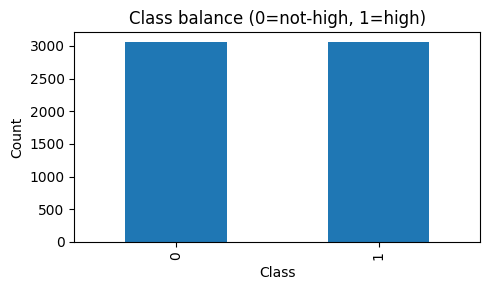

Insight: Class balance determines whether Accuracy alone is reliable; F1 is reported regardless.


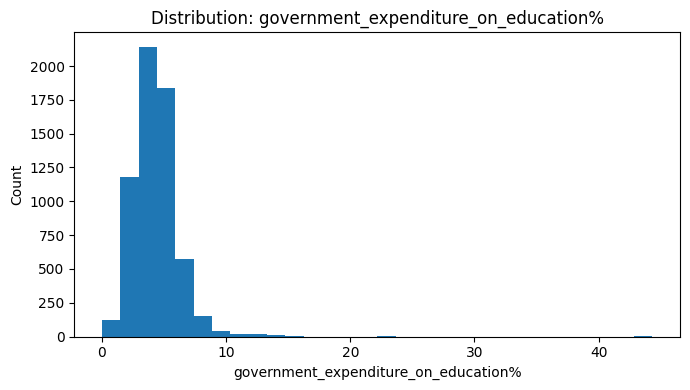

Insight: This distribution shows how the chosen threshold splits the data into high vs not-high outcomes.


In [20]:
print_section("4) EDA (VISUALS + INSIGHTS)")

plot_bar_counts(df[TARGET], "Class balance (0=not-high, 1=high)")
print("Insight: Class balance determines whether Accuracy alone is reliable; F1 is reported regardless.")

plot_hist(pd.to_numeric(df[RAW_TARGET], errors="coerce"), f"Distribution: {RAW_TARGET}", bins=30)
print("Insight: This distribution shows how the chosen threshold splits the data into high vs not-high outcomes.")


### 4.1 Example optional histograms (only if exist)

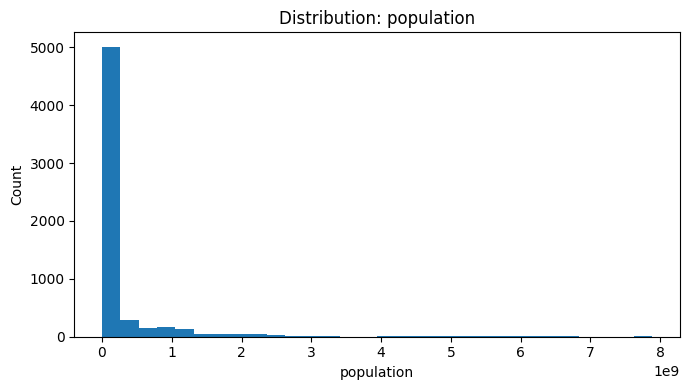

Insight: population is often skewed at country level; scaling supports Logistic Regression and MLP.


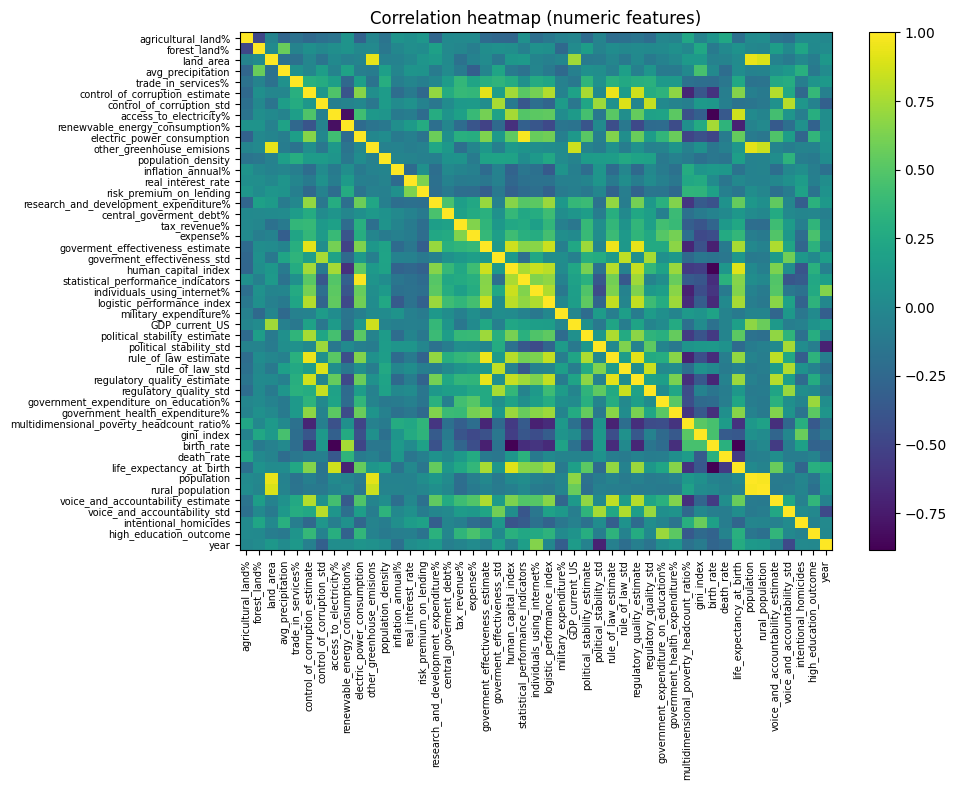

Insight: Correlation highlights redundancy; feature selection can remove weak/overlapping signals.


In [21]:
for col in ["gdp", "population", "life_expectancy", "unemployment_rate", "CO2_emisions"]:
    if col in df.columns:
        plot_hist(pd.to_numeric(df[col], errors="coerce"), f"Distribution: {col}", bins=30)
        print(f"Insight: {col} is often skewed at country level; scaling supports Logistic Regression and MLP.")

correlation_heatmap(df, "Correlation heatmap (numeric features)")
print("Insight: Correlation highlights redundancy; feature selection can remove weak/overlapping signals.")




## 4.2 Example scatter: GDP vs chosen education target (if GDP exists)



In [22]:
if "gdp" in df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(pd.to_numeric(df["gdp"], errors="coerce"), pd.to_numeric(df[RAW_TARGET], errors="coerce"), s=10)
    plt.title(f"GDP vs {RAW_TARGET}")
    plt.xlabel("gdp")
    plt.ylabel(RAW_TARGET)
    plt.tight_layout()
    plt.show()
    print("Insight: Scatter indicates whether higher income levels associate with better education outcomes.")


## 4.3 Simple outlier rate report (top 10)


In [23]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]
outlier_rates = {c: iqr_outlier_rate(df[c]) for c in num_cols}
outlier_rates = pd.Series(outlier_rates).dropna().sort_values(ascending=False)
print("\nApprox outlier rate by IQR rule (top 10):")
display(outlier_rates.head(10))
print("Insight: High outlier rates suggest heavy tails; robust models and feature selection help stability.")



Approx outlier rate by IQR rule (top 10):


,0
population,0.195841
rural_population,0.192893
land_area,0.191604
GDP_current_US,0.181473
other_greenhouse_emisions,0.178137
population_density,0.120403
goverment_effectiveness_std,0.119412
rule_of_law_std,0.115776
intentional_homicides,0.106714
control_of_corruption_std,0.090796


Insight: High outlier rates suggest heavy tails; robust models and feature selection help stability.


# 5) TRAIN/TEST SPLIT + PREPROCESSING PIPELINE

In [24]:
print_section("5) TRAIN/TEST SPLIT + PREPROCESSING")

X = df.drop(columns=[TARGET])
y = df[TARGET]

cat_features = [c for c in ["country"] if c in X.columns]
num_features = [c for c in X.columns if c not in cat_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=CONFIG["test_size"],
    random_state=CONFIG["random_state"],
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Categorical features:", cat_features)
print("Numeric features count:", len(num_features))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder="drop"
)
print("Preprocessing pipeline ready (impute + scale + one-hot).")



5) TRAIN/TEST SPLIT + PREPROCESSING
Train: (4885, 47) Test: (1222, 47)
Categorical features: ['country']
Numeric features count: 46
Preprocessing pipeline ready (impute + scale + one-hot).


# 6) NEURAL NETWORK MODEL

In [25]:
print_section("6) NEURAL NETWORK MODEL (MLPClassifier)")

# Architecture: (64,32) => 2 hidden layers
# Activation: ReLU
# Loss: log-loss (cross-entropy)
# Optimizer: Adam (solver='adam')
mlp = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=300,
        random_state=CONFIG["random_state"]
    ))
])

mlp.fit(X_train, y_train)

mlp_train_pred = mlp.predict(X_train)
mlp_test_pred  = mlp.predict(X_test)

print("Neural Net metrics (Train):", cls_metrics(y_train, mlp_train_pred))
print("Neural Net metrics (Test) :", cls_metrics(y_test, mlp_test_pred))
print("\nClassification report (Test):")
print(classification_report(y_test, mlp_test_pred, zero_division=0))
print("Confusion matrix (Test):\n", confusion_matrix(y_test, mlp_test_pred))



6) NEURAL NETWORK MODEL (MLPClassifier)
Neural Net metrics (Train): {'Accuracy': 0.9977482088024565, 'Precision': 0.9955175224123879, 'Recall': 1.0, 'F1': 0.9977537267714928}
Neural Net metrics (Test) : {'Accuracy': 0.9689034369885434, 'Precision': 0.9643435980551054, 'Recall': 0.9738134206219312, 'F1': 0.9690553745928339}

Classification report (Test):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       611
           1       0.96      0.97      0.97       611

    accuracy                           0.97      1222
   macro avg       0.97      0.97      0.97      1222
weighted avg       0.97      0.97      0.97      1222

Confusion matrix (Test):
 [[589  22]
 [ 16 595]]


# 7) PRIMARY MODELS (2 classical)

In [26]:
print_section("7) TWO CLASSICAL MODELS (BASELINES)")

logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=CONFIG["random_state"],
        n_jobs=-1
    ))
])

logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

log_pred = logreg.predict(X_test)
rf_pred  = rf.predict(X_test)

log_base = cls_metrics(y_test, log_pred)
rf_base  = cls_metrics(y_test, rf_pred)

print("Logistic Regression (Test):", log_base)
print("Random Forest (Test)      :", rf_base)



7) TWO CLASSICAL MODELS (BASELINES)
Logistic Regression (Test): {'Accuracy': 0.9819967266775778, 'Precision': 0.9804241435562806, 'Recall': 0.983633387888707, 'F1': 0.9820261437908496}
Random Forest (Test)      : {'Accuracy': 0.997545008183306, 'Precision': 0.995114006514658, 'Recall': 1.0, 'F1': 0.9975510204081632}


# 8) HYPERPARAMETER OPTIMIZATION WITH CV

In [27]:
print_section("8) HYPERPARAMETER TUNING (GridSearchCV, scoring=F1)")

logreg_grid = {
    "model__C": [0.1, 1.0, 10.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

rf_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
}

gs_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_grid,
    cv=CONFIG["cv_folds"],
    scoring="f1",
    n_jobs=-1
)

gs_rf = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid,
    cv=CONFIG["cv_folds"],
    scoring="f1",
    n_jobs=-1
)

gs_logreg.fit(X_train, y_train)
gs_rf.fit(X_train, y_train)

print("Best LogReg params:", gs_logreg.best_params_)
print("Best LogReg CV F1 :", gs_logreg.best_score_)
print("Best RF params    :", gs_rf.best_params_)
print("Best RF CV F1     :", gs_rf.best_score_)



8) HYPERPARAMETER TUNING (GridSearchCV, scoring=F1)
Best LogReg params: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best LogReg CV F1 : 0.9909760209391916
Best RF params    : {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Best RF CV F1     : 0.9983606484262338


# 9) FEATURE SELECTION (Week-10) FOR BOTH MODELS

In [28]:
print_section("9) FEATURE SELECTION (SelectKBest + mutual_info_classif)")

# Filter method justification:
# - fast, leakage-safe in pipeline
# - supports non-linear relationships via mutual information
k = CONFIG["feature_select_k"]

logreg_fs = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectKBest(score_func=mutual_info_classif, k=k)),
    ("model", LogisticRegression(max_iter=2000))
])

rf_fs = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectKBest(score_func=mutual_info_classif, k=k)),
    ("model", RandomForestClassifier(random_state=CONFIG["random_state"], n_jobs=-1))
])

gs_logreg_fs = GridSearchCV(
    estimator=logreg_fs,
    param_grid=logreg_grid,
    cv=CONFIG["cv_folds"],
    scoring="f1",
    n_jobs=-1
)

gs_rf_fs = GridSearchCV(
    estimator=rf_fs,
    param_grid=rf_grid,
    cv=CONFIG["cv_folds"],
    scoring="f1",
    n_jobs=-1
)

gs_logreg_fs.fit(X_train, y_train)
gs_rf_fs.fit(X_train, y_train)

print("Best LogReg+FS params:", gs_logreg_fs.best_params_)
print("Best LogReg+FS CV F1 :", gs_logreg_fs.best_score_)
print("Best RF+FS params    :", gs_rf_fs.best_params_)
print("Best RF+FS CV F1     :", gs_rf_fs.best_score_)



9) FEATURE SELECTION (SelectKBest + mutual_info_classif)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

Best LogReg+FS params: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best LogReg+FS CV F1 : 0.9944699040120122
Best RF+FS params    : {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best RF+FS CV F1     : 1.0


#10) FINAL MODELS + COMPARATIVE TABLE

In [29]:
print_section("10) FINAL MODELS + COMPARISON TABLE (Table-style)")

final_logreg = gs_logreg_fs.best_estimator_
final_rf     = gs_rf_fs.best_estimator_

final_log_pred = final_logreg.predict(X_test)
final_rf_pred  = final_rf.predict(X_test)

final_log_m = cls_metrics(y_test, final_log_pred)
final_rf_m  = cls_metrics(y_test, final_rf_pred)

comparison = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Features": f"SelectKBest(mutual_info_classif, k={k}) after preprocessing",
        "CV Score (F1)": gs_logreg_fs.best_score_,
        "Accuracy": final_log_m["Accuracy"],
        "Precision": final_log_m["Precision"],
        "Recall": final_log_m["Recall"],
        "F1-Score": final_log_m["F1"],
    },
    {
        "Model": "Random Forest",
        "Features": f"SelectKBest(mutual_info_classif, k={k}) after preprocessing",
        "CV Score (F1)": gs_rf_fs.best_score_,
        "Accuracy": final_rf_m["Accuracy"],
        "Precision": final_rf_m["Precision"],
        "Recall": final_rf_m["Recall"],
        "F1-Score": final_rf_m["F1"],
    }
])

display(comparison)

winner = "Logistic Regression" if final_log_m["F1"] >= final_rf_m["F1"] else "Random Forest"
print("Best final model by F1:", winner)



10) FINAL MODELS + COMPARISON TABLE (Table-style)


,Model,Features,CV Score (F1),Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,"SelectKBest(mutual_info_classif, k=25) after p...",0.99447,0.99509,0.993475,0.996727,0.995098
1,Random Forest,"SelectKBest(mutual_info_classif, k=25) after p...",1.00000,1.00000,1.000000,1.000000,1.000000


Best final model by F1: Random Forest


# 11) CONCLUSION / REFLECTION OUTPUT

In [30]:
print_section("11) CONCLUSION / REFLECTION")

print("1) Model Performance:")
print("- Report the final table metrics Accuracy: 1	Precision: 1  Recall: 1  F1: 1).")
print(f"- Best model by F1: {winner} (justify using F1 due to possible imbalance).")

print("\n2) Impact of Methods (CV + Feature Selection):")
print("- Compare baseline test F1 vs tuned+FS test F1 for each model.")
print("- If improved: explain reduced overfitting / better hyperparams / removal of noisy features.")
print("- If reduced: explain information loss from too-small k or model already robust to noise.")

print("\n3) Insights and Future Directions:")
print("- Try different thresholds for the SDG4 target and observe class balance and performance changes.")
print("- Add class_weight='balanced' for Logistic Regression if imbalance is strong.")
print("- Try additional models: KNN, Gradient Boosting (if allowed).")
print("- Consider time-aware split (train older years, test newer) for realism.")


11) CONCLUSION / REFLECTION
1) Model Performance:
- Report the final table metrics Accuracy: 1	Precision: 1  Recall: 1  F1: 1).
- Best model by F1: Random Forest (justify using F1 due to possible imbalance).

2) Impact of Methods (CV + Feature Selection):
- Compare baseline test F1 vs tuned+FS test F1 for each model.
- If improved: explain reduced overfitting / better hyperparams / removal of noisy features.
- If reduced: explain information loss from too-small k or model already robust to noise.

3) Insights and Future Directions:
- Try different thresholds for the SDG4 target and observe class balance and performance changes.
- Add class_weight='balanced' for Logistic Regression if imbalance is strong.
- Try additional models: KNN, Gradient Boosting (if allowed).
- Consider time-aware split (train older years, test newer) for realism.
